# PyRATES Reproducibility Study

## Koslow et al. (2011) "Impact of declining intermediate-water oxygen on deepwater fishes in the California Current"
[Link to study](https://www.researchgate.net/publication/263583233_Impact_of_declining_intermediate-water_oxygen_on_deepwater_fishes_in_the_California_Current)

***

### 0. Set Up

Load libraries.

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pca import pca
from scipy.stats import pearsonr

***

### 1. Get and Process CalCOFI Ichthyoplankton Data

CalCOFI ichthyoplankton data is hosted here on [ERDDAP](https://coastwatch.pfeg.noaa.gov/erddap/tabledap/erdCalCOFIlrvcnt.html).

The analysis in this paper includes data from 3 species' eggs in addition to the ichthyoplankton data. As of last check on 7/30/24, the link to the CalCOFI egg count positive tows dataset on [calcofi.org](https://calcofi.org/data/marine-ecosystem-data/fish-eggs-larvae/) is giving a 404 error. For now I will just work with the ichthyoplankton data.

Manual step: query ERDDAP.
- check all variables
- constrain the time >= 1951-01-18T00:00:00Z and <= 2008-12-31T23:59:59Z
- download the data as a csv file

Read in the data.

In [61]:
# there is a datetime column; use this as the index
df = pd.read_csv("calcofi-ichthyo.csv",
                 index_col = 7, parse_dates = True)

/var/folders/_z/5bhzcmhj3lj_8k6z_lddq8g40000gn/T/ipykernel_4019/2846426706.py:2: DtypeWarning: Columns (8,9,13,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("calcofi-ichthyo.csv",
/var/folders/_z/5bhzcmhj3lj_8k6z_lddq8g40000gn/T/ipykernel_4019/2846426706.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("calcofi-ichthyo.csv",


Check the column names of the data.

In [62]:
display(df.columns)

Index(['cruise', 'ship', 'ship_code', 'order_occupied', 'tow_type',
       'tow_number', 'net_location', 'latitude', 'longitude', 'line',
       'station', 'standard_haul_factor', 'volume_sampled',
       'proportion_sorted', 'scientific_name', 'common_name', 'itis_tsn',
       'calcofi_species_code', 'larvae_count', 'larvae_10m2', 'larvae_100m3'],
      dtype='object')

View the first few rows of the data.

In [63]:
display(df.head())

,cruise,ship,ship_code,order_occupied,tow_type,tow_number,net_location,latitude,longitude,line,...,standard_haul_factor,volume_sampled,proportion_sorted,scientific_name,common_name,itis_tsn,calcofi_species_code,larvae_count,larvae_10m2,larvae_100m3
time,,,,,,,,,,,,,,,,,,,,,
UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,degrees_north,degrees_east,NaN,...,NaN,meters^3,NaN,NaN,NaN,NaN,NaN,NaN,Larvae 10/M^2,Larvae 100/M^3
1951-01-19T07:25:00Z,195101.0,SCOFIELD,47,1.0,C1,1.0,S,33.833332,-118.625,86.7,...,1.65,892.6,1.0,Citharichthys,Sanddabs,172715.0,924.0,2.0,3.3,NaN
1951-01-19T07:25:00Z,195101.0,SCOFIELD,47,1.0,C1,1.0,S,33.833332,-118.625,86.7,...,1.65,892.6,1.0,Engraulis mordax,Northern anchovy,161828.0,31.0,103.0,169.95,NaN
1951-01-19T07:25:00Z,195101.0,SCOFIELD,47,1.0,C1,1.0,S,33.833332,-118.625,86.7,...,1.65,892.6,1.0,Gobiidae,Gobies,171746.0,795.0,1.0,1.65,NaN
1951-01-19T07:25:00Z,195101.0,SCOFIELD,47,1.0,C1,1.0,S,33.833332,-118.625,86.7,...,1.65,892.6,1.0,Leuroglossus stilbius,California smoothtongue,162096.0,72.0,134.0,221.1,NaN


Select just the needed columns: line, station, scientific name, and larval abundance.

In [64]:
# get just the columns we need
df = (df.filter(items =["line","station","scientific_name", "larvae_10m2"])
        .dropna())

# show the first few observations in the new dataframe
display(df.head())

,line,station,scientific_name,larvae_10m2
time,,,,
1951-01-19T07:25:00Z,86.7,35.0,Citharichthys,3.3
1951-01-19T07:25:00Z,86.7,35.0,Engraulis mordax,169.95
1951-01-19T07:25:00Z,86.7,35.0,Gobiidae,1.65
1951-01-19T07:25:00Z,86.7,35.0,Leuroglossus stilbius,221.1
1951-01-19T07:25:00Z,86.7,35.0,Lipolagus ochotensis,1.65


Build a dataframe with the lines and stations used in the study.

Note that the text says that 51 stations were used; however, the map in Figure 1 seems to have 55 stations in the outlined region. I am including all 55 of these stations because it is not clear which ones were removed from the study.

In [65]:
# create a DataFrame with lines as columns and stations as rows
stations = pd.DataFrame(
   {"76.7" : [80, 70, 60, 55, 51, 49, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA],
    "80" : [100, 90, 80, 70, 60, 55, 51, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA],
    "81.8" : [46.9, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA],
    "83.3" : [90, 80, 70, 60, 55, 51, 42, 40.6, pd.NA, pd.NA, pd.NA, pd.NA],
    "86.7" : [90, 80, 70, 60, 55, 50, 45, 40, 35, 33, pd.NA, pd.NA],
    "90" : [100, 90, 80, 70, 60, 53, 45, 37, 35, 30, 28, pd.NA],
    "93.3" : [90, 80, 70, 60, 55, 50, 45, 40, 35, 30, 28, 26.7]
    }
)

# melt the df to get a row for each line-station combination
stations = (pd.melt(stations,
                   var_name = "line",
                   value_name = "station")
               .dropna() # now drop the NA values
               .astype('float64') # coerce to float64 to facilitate merging later
               )

# count the number of stations to check there are 55
display(len(stations))

55

Filter for the stations used in the study.

In [66]:
# inner join to keep only the rows with the correct line-stations we are keeping
df2 = (df.reset_index() # move the datetime index to a regular column
        .merge(stations,
               how = "inner",
               left_on = ["line", "station"],
               right_on = ["line", "station"]) # do the merge
        .set_index("time")) # reset the datetime column to index

# count the number of observations at each line-station
observations = df2.groupby(["line","station"]).size()

# count again to check there are still 55 stations
display(len(observations))

55

Filter for only taxa identified to species... is what I did originally but now I see the authors have kept some larger taxonomic groupings, so I will skip this step.

In [67]:
# since species names are "Genus species", they all contain a space, so I will filter the scientific_name column for just the ones that contain a space
# df3 = df2[df2["scientific_name"].str.contains(" ")]

df3 = df2

# count the number of TAXA currently included
display(len(df3["scientific_name"].unique()))

364

Assign seasons to the dates. In the text, it says Jan-Feb = winter, Mar-May = spring, Jun-Aug = summer, Sep-Dec = fall.

In [68]:
# make sure the index is of datetime type
df3.index = pd.to_datetime(df3.index, utc = True)

# code the seasons based on the month column
df3.loc[df3.index.month.isin([1,2]),"season"] = "Winter"
df3.loc[df3.index.month.isin([3,4,5]),"season"] = "Spring"
df3.loc[df3.index.month.isin([6,7,8]),"season"] = "Summer"
df3.loc[df3.index.month.isin([9,10,11,12]),"season"] = "Fall"

# show the last few rows
display(df3.tail())



,line,station,scientific_name,larvae_10m2,season
time,,,,,
2008-10-29 10:54:00+00:00,76.7,51.0,Triphoturus mexicanus,5.2,Fall
2008-10-29 13:24:00+00:00,76.7,49.0,Leptocottus armatus,4.49,Fall
2008-10-29 13:24:00+00:00,76.7,49.0,Sebastes,4.49,Fall
2008-10-30 09:53:00+00:00,90.0,45.0,Chauliodus macouni,5.3,Fall
2008-10-30 09:53:00+00:00,90.0,45.0,Rhinogobiops nicholsii,5.3,Fall


Remove years with < three seasons of data.

In [69]:
# make a new column with the index year
df3["year"] = df3.index.year

# for each year, count the number of seasons of data present
seasons = (df3.filter(items = ["year", "season"])
           .groupby("year") # group by year
           .nunique() # count the seasons each year has
           .rename(columns = {"season": "count"}) # name the count column "count"
           .reset_index() # ungroup
           )

# drop the years that have less than 3 seasons of data
df3 = df3.drop(
    df3[df3.year.isin(seasons.query("count < 3")["year"])].index # get the index values matching this query
    ) # then drop those rows

# print the years remaining and the years that have been dropped
display(df3["year"].unique())
display(seasons.query("count < 3")["year"])

array([1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1969, 1972, 1975, 1978, 1980, 1981,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008], dtype=int32)

16    1967
17    1968
20    1974
22    1977
24    1979
27    1982
28    1983
Name: year, dtype: int32

Calculate seasonal means (for each year, each season) of larval abundance.

In [70]:
# make sure the abundance column is numeric
df3["larvae_10m2"] = pd.to_numeric(df3["larvae_10m2"])

# print the data types
display(df3.dtypes)

line               float64
station            float64
scientific_name     object
larvae_10m2        float64
season              object
year                 int32
dtype: object

In [71]:
# group by year, season, and taxa. then take the mean of the larval abundance
seasonalMeans = (df3.filter(["year","season","scientific_name","larvae_10m2"])
                 .groupby(["year","season","scientific_name"]) # group by year, season, taxa
                 .mean() # take the mean of larvae_10m2
                 .reset_index() # ungroup
                 )

# show the first few rows
display(seasonalMeans.head())

,year,season,scientific_name,larvae_10m2
0,1951,Fall,Bathylagoides wesethi,5.700000
1,1951,Fall,Brama japonica,6.680000
2,1951,Fall,Ceratoscopelus townsendi,7.066667
3,1951,Fall,Chauliodus macouni,2.940000
4,1951,Fall,Chromis punctipinnis,6.870000


Calculate annual means of larval abundance.

In [72]:
# group by year and taxa, then take the mean of the seasonal abundances
annualMeans = (seasonalMeans.filter(["year", "scientific_name", "larvae_10m2"])
               .groupby(["year", "scientific_name"]) # group by year and taxa
               .mean() # take the mean of larvae_10m2
               .reset_index() # ungroup
               )

# show the last few rows
display(annualMeans.tail())

,year,scientific_name,larvae_10m2
5759,2008,Trachurus symmetricus,11.462500
5760,2008,Triphoturus mexicanus,15.780282
5761,2008,Vinciguerria lucetia,13.550469
5762,2008,Xeneretmus latifrons,23.549718
5763,2008,Zaniolepis frenata,7.329231


Remove species with data in < half the years. We should end up with larval abundance observations for roughly 86 taxa.

In [73]:
# for each taxon, count how many years of data they have
yearsOfData = (annualMeans.filter(["year", "scientific_name"])
               .groupby(["scientific_name"]) # group by taxa
               .nunique() # count the number of years each taxon has
               .rename(columns = {"year": "count"}) # name the count column "count"
               .reset_index() # ungroup
               )

# drop taxa with years of data less than the threshold (29, half the length of the time series)
annualMeans = annualMeans.drop(
    annualMeans[annualMeans.scientific_name.isin(
        yearsOfData.query("count < 29")["scientific_name"]
        )].index # get the index values matching this query
    ) # then drop those rows

# count the taxa remaining
display(len(annualMeans["scientific_name"].unique()))

93

We still have 93 taxa. Besides occurrence in at least half the years, the other condition stated in the paper was "consistent identification and enumeration since 1951". Let's plot the timeseries of annual abundance for each species.

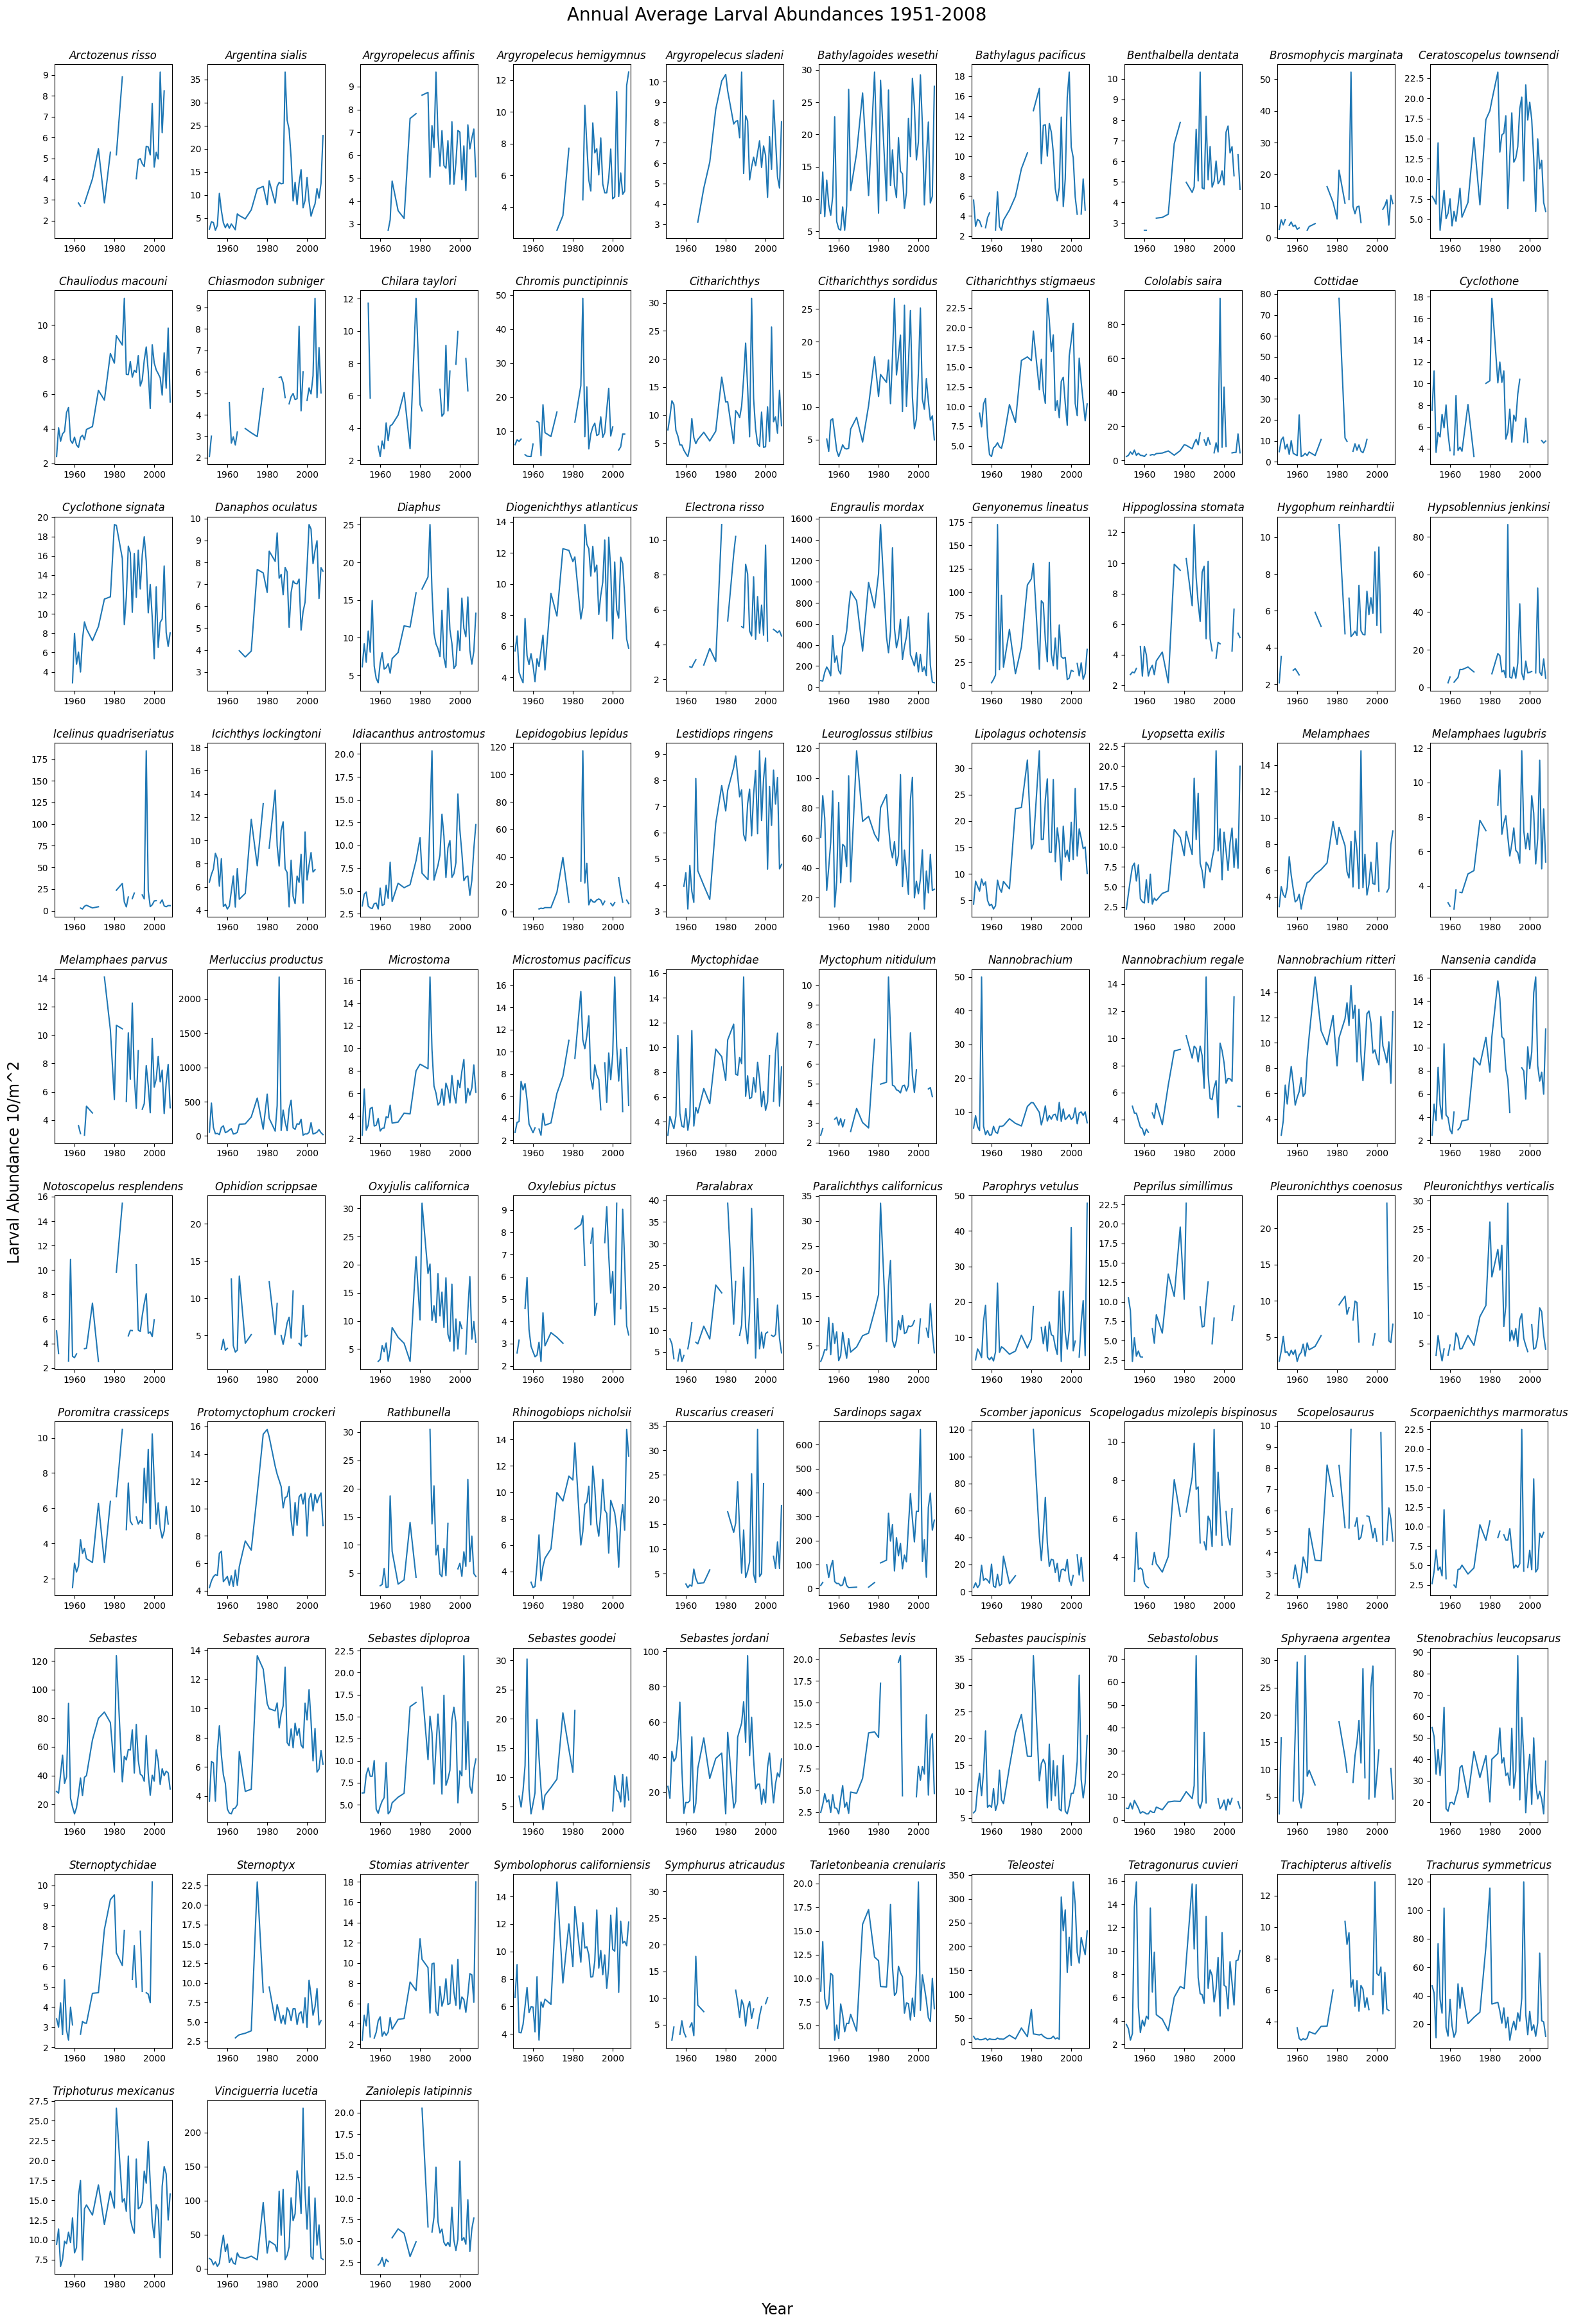

In [74]:
# pivot_longer to get a column for each species
annualMeansPlot = annualMeans.pivot_table(values="larvae_10m2", index="year", columns="scientific_name")

# plot set up
fig, axs = plt.subplots(nrows = 10, ncols = 10, # layout of subplots
                        figsize = (30,45)) # figure size
fig.subplots_adjust(wspace = 0.3, hspace = 0.3, bottom = 0.115, top = 0.88) # adjust white space in figure
fig.suptitle("Annual Average Larval Abundances 1951-2008", fontsize = 20, y = 0.9) # set overall title
fig.supxlabel("Year", fontsize = 17, y = 0.1) # set overall x axis label
fig.supylabel("Larval Abundance 10/m^2", fontsize = 17, x = 0.1) # set overall y axis label
plt.setp(axs, xlim = (1950, 2009)) # set overall x axis limits

# populate the subplots
for col, ax in zip(annualMeansPlot.columns, axs.ravel()):
    annualMeansPlot[[col]].plot(ax = ax)

    ax.set_title(col, style = "italic") # subplot title = taxon name in italics
    ax.get_legend().remove() # no subplot legend
    ax.set_xlabel("", fontsize = 16) #blank subplot xlabel

# delete empty subplots
for i in range(3,10):
    fig.delaxes(axs[9, i])

# display the figure
plt.show()

# this cell should take 10-15 secs to run

I will drop 'Teleostei' because that grouping is too broad. Then I will leave the rest of the taxa in.

In [75]:
# drop Teleostei
annualMeans = annualMeans[annualMeans["scientific_name"] != "Teleostei"]

# count the taxa remaining, there should be 92
display(len(annualMeans["scientific_name"].unique()))

92

Log-transform the annual means. The paper does not specify what kind of log transformation.

In [76]:
# the abundance figure (fig 2) in the paper has the abundance axis labeled as log(#/m^2)
annualMeans["larvae_m2"] = annualMeans["larvae_10m2"] / 10 # this conversion seems unlikely because it leads to small x values < 1 --> negative log(x) while the results in the figure are entirely ≥ 0. I think it may be a mistake and I will continue to use the larvae_10m2.

# apply log transformation to larvae_10m2. I will try a few different log transformations and see which matches the paper results most closely.
annualMeans["log10_larvae"] = np.log10(annualMeans["larvae_10m2"]) # log10(x)
annualMeans["ln_larvae"] = np.log(annualMeans["larvae_10m2"]) # ln(x)
annualMeans["ln_x1_larvae"] = np.log(annualMeans["larvae_10m2"] + 1) # ln(x + 1)

# show the first few columns
display(annualMeans.head())

,year,scientific_name,larvae_10m2,larvae_m2,log10_larvae,ln_larvae,ln_x1_larvae
1,1951,Argentina sialis,2.637500,0.263750,0.421192,0.969831,1.291297
2,1951,Bathylagoides wesethi,7.776321,0.777632,0.890774,2.051083,2.172057
3,1951,Bathylagus pacificus,5.600000,0.560000,0.748188,1.722767,1.887070
5,1951,Brosmophycis marginata,2.640000,0.264000,0.421604,0.970779,1.291984
6,1951,Ceratoscopelus townsendi,7.839722,0.783972,0.894301,2.059203,2.179255


***

### 2. Get and Process CalCOFI Oxygen Data

CalCOFI midwater oxygen data is included in the [Bottle Database](https://calcofi.org/data/oceanographic-data/bottle-database/).

Manual step: download CalCOFI bottle database and save as csv file.

Read in the data. Currently the bottle csv is just on my local device because it is too large to push to GitHub.

In [77]:
# the fourth column, Depth_ID, will be used as the index
oxygen = pd.read_csv("~/Desktop/PyRATES/pyrates/calcofi-bottle.csv",
                     index_col = 3)

/var/folders/_z/5bhzcmhj3lj_8k6z_lddq8g40000gn/T/ipykernel_4019/2048121777.py:2: DtypeWarning: Columns (47,61) have mixed types. Specify dtype option on import or set low_memory=False.
  oxygen = pd.read_csv("~/Desktop/PyRATES/pyrates/calcofi-bottle.csv",


Check the column names of the data.

In [78]:
display(oxygen.columns)

Index(['Cst_Cnt', 'Btl_Cnt', 'Sta_ID', 'Depthm', 'T_degC', 'Salnty', 'O2ml_L',
       'STheta', 'O2Sat', 'Oxy_micromol/Kg', 'BtlNum', 'RecInd', 'T_prec',
       'T_qual', 'S_prec', 'S_qual', 'P_qual', 'O_qual', 'SThtaq', 'O2Satq',
       'ChlorA', 'Chlqua', 'Phaeop', 'Phaqua', 'PO4uM', 'PO4q', 'SiO3uM',
       'SiO3qu', 'NO2uM', 'NO2q', 'NO3uM', 'NO3q', 'NH3uM', 'NH3q', 'C14As1',
       'C14A1p', 'C14A1q', 'C14As2', 'C14A2p', 'C14A2q', 'DarkAs', 'DarkAp',
       'DarkAq', 'MeanAs', 'MeanAp', 'MeanAq', 'IncTim', 'LightP', 'R_Depth',
       'R_TEMP', 'R_Sal', 'R_DYNHT', 'R_Nuts', 'R_Oxy_µmol/Kg', 'DIC1', 'DIC2',
       'TA1', 'TA2', 'pH1', 'pH2', 'DIC Quality Comment'],
      dtype='object')

View the first few rows of the data.

In [79]:
display(oxygen.head())

,Cst_Cnt,Btl_Cnt,Sta_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_micromol/Kg,...,R_DYNHT,R_Nuts,R_Oxy_µmol/Kg,DIC1,DIC2,TA1,TA2,pH1,pH2,DIC Quality Comment
Depth_ID,,,,,,,,,,,,,,,,,,,,,
19-4903CR-HY-060-0930-05400560-0000A-3,1,1,054.0 056.0,0,10.50,33.440,NaN,25.649,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19-4903CR-HY-060-0930-05400560-0008A-3,1,2,054.0 056.0,8,10.46,33.440,NaN,25.656,NaN,NaN,...,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19-4903CR-HY-060-0930-05400560-0010A-7,1,3,054.0 056.0,10,10.46,33.437,NaN,25.654,NaN,NaN,...,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19-4903CR-HY-060-0930-05400560-0019A-3,1,4,054.0 056.0,19,10.45,33.420,NaN,25.643,NaN,NaN,...,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19-4903CR-HY-060-0930-05400560-0020A-7,1,5,054.0 056.0,20,10.45,33.421,NaN,25.643,NaN,NaN,...,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Subset for only the columns we need-- Sta_ID (contains line and station), Depthm, O2ml_L.

In [80]:
# get just the columns we need and drop NA values
oxygen = (oxygen.filter(items =["Sta_ID","Depthm", "O2ml_L"])
                .dropna())

# show the first few observations in the new dataframe
display(oxygen.head())

,Sta_ID,Depthm,O2ml_L
Depth_ID,,,
19-4904CR-HY-087-0606-04400485-0000B-3,044.0 048.5,0,5.90
19-4904CR-HY-087-0606-04400485-0006A-3,044.0 048.5,6,6.02
19-4904CR-HY-087-0606-04400485-0010A-7,044.0 048.5,10,6.04
19-4904CR-HY-087-0606-04400485-0015A-3,044.0 048.5,15,6.06
19-4904CR-HY-087-0606-04400485-0020A-7,044.0 048.5,20,6.04


Filter for the years 1951-2008. Date identifiers are included in the Depth_ID index; the first five characters are [Century]-[Year].

In [81]:
# extract the first five characters of the Depth_ID string and put them in a new column Year
oxygen = oxygen.assign(Year = oxygen.index.str[:5]) 

# remove the "-" character from the Year column
oxygen["Year"] = oxygen["Year"].str.replace(r'\-', '', regex=True)

# make the Year column numeric
oxygen["Year"] = pd.to_numeric(oxygen["Year"])

# filter for the years 1951-2008 and save the result in a new df
oxygen2 = oxygen.query("Year >= 1951 & Year <= 2008")

# show the last few rows
display(oxygen2.tail())

,Sta_ID,Depthm,O2ml_L,Year
Depth_ID,,,,
20-0810NM-MX-288-2117-09340264-0005A-3,093.4 026.4,5,5.96,2008
20-0810NM-MX-288-2117-09340264-0010A-3,093.4 026.4,10,5.62,2008
20-0810NM-MX-288-2117-09340264-0015A-3,093.4 026.4,15,5.28,2008
20-0810NM-MX-288-2117-09340264-0020A-7,093.4 026.4,20,5.11,2008
20-0810NM-MX-288-2117-09340264-0021A-3,093.4 026.4,21,5.08,2008


Filter for the select stations used in this study.

In [82]:
# split the "Sta_ID" column into a "line" column and "station" column and make those columns floats
oxygen2[["line", "station"]] = oxygen2["Sta_ID"].str.split(' ', n = 1, expand = True).astype('float64')

# inner join with the stations dataframe to keep only the rows with the correct line-stations
oxygen3 = (oxygen2.reset_index() # move the index to a regular column
                  .merge(stations,
                         how = "inner",
                         left_on = ["line", "station"],
                         right_on = ["line", "station"]) # do the merge
                  .set_index("Depth_ID")) # reset the Depth_ID column to index

# count the number of observations at each line-station
oxygenObservations = oxygen3.groupby(["line","station"]).size()

# count again to check there are 55 stations of data
display(len(oxygenObservations))

# show the first few rows
display(oxygen3.head())

/var/folders/_z/5bhzcmhj3lj_8k6z_lddq8g40000gn/T/ipykernel_4019/2070318833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oxygen2[["line", "station"]] = oxygen2["Sta_ID"].str.split(' ', n = 1, expand = True).astype('float64')
/var/folders/_z/5bhzcmhj3lj_8k6z_lddq8g40000gn/T/ipykernel_4019/2070318833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oxygen2[["line", "station"]] = oxygen2["Sta_ID"].str.split(' ', n = 1, expand = True).astype('float64')


55

,Sta_ID,Depthm,O2ml_L,Year,line,station
Depth_ID,,,,,,
19-5101CR-HY-017-0448-09001000-0000B-3,090.0 100.0,0,4.82,1951,90.0,100.0
19-5101CR-HY-017-0448-09001000-0020A-7,090.0 100.0,20,4.99,1951,90.0,100.0
19-5101CR-HY-017-0448-09001000-0030A-7,090.0 100.0,30,5.07,1951,90.0,100.0
19-5101CR-HY-017-0448-09001000-0050A-7,090.0 100.0,50,5.24,1951,90.0,100.0
19-5101CR-HY-017-0448-09001000-0075A-7,090.0 100.0,75,5.45,1951,90.0,100.0


Filter for depths 200-400m.

In [83]:
# query the Depthm column for values between 200 and 400
oxygen3 = oxygen3.query("Depthm >= 200 & Depthm <= 400")

# show the first few rows
display(oxygen3.head())

,Sta_ID,Depthm,O2ml_L,Year,line,station
Depth_ID,,,,,,
19-5101CR-HY-017-0448-09001000-0200A-7,090.0 100.0,200,4.59,1951,90.0,100.0
19-5101CR-HY-017-0448-09001000-0250A-7,090.0 100.0,250,3.94,1951,90.0,100.0
19-5101CR-HY-017-0448-09001000-0300A-7,090.0 100.0,300,3.13,1951,90.0,100.0
19-5101CR-HY-017-0448-09001000-0317A-3,090.0 100.0,317,2.81,1951,90.0,100.0
19-5101CR-HY-017-0448-09001000-0400A-7,090.0 100.0,400,1.71,1951,90.0,100.0


Assign seasons to the data.

In [84]:
# extract the month from the Depth_ID index
oxygen3 = oxygen3.assign(Month = oxygen3.index.str[5:7])
oxygen3["Month"] = pd.to_numeric(oxygen3["Month"]) # make numeric

# code the seasons based on the month column
oxygen3.loc[oxygen3.Month.isin([1,2]),"season"] = "Winter"
oxygen3.loc[oxygen3.Month.isin([3,4,5]),"season"] = "Spring"
oxygen3.loc[oxygen3.Month.isin([6,7,8]),"season"] = "Summer"
oxygen3.loc[oxygen3.Month.isin([9,10,11,12]),"season"] = "Fall"

# show the last few rows
display(oxygen3.tail())

,Sta_ID,Depthm,O2ml_L,Year,line,station,Month,season
Depth_ID,,,,,,,,
20-0810NM-MX-290-2355-09330900-0269A-3,093.3 090.0,269,1.59,2008,93.3,90.0,10,Fall
20-0810NM-MX-290-2355-09330900-0300A-7,093.3 090.0,300,1.36,2008,93.3,90.0,10,Fall
20-0810NM-MX-290-2355-09330900-0317A-3,093.3 090.0,317,1.25,2008,93.3,90.0,10,Fall
20-0810NM-MX-290-2355-09330900-0376A-3,093.3 090.0,376,0.77,2008,93.3,90.0,10,Fall
20-0810NM-MX-290-2355-09330900-0400A-7,093.3 090.0,400,0.67,2008,93.3,90.0,10,Fall


Remove years with < three seasons of data.

In [85]:
# for each year, count the number of seasons of data present
oxygenSeasons = (oxygen3.filter(items = ["Year", "season"])
           .groupby("Year") # group by year
           .nunique() # count the seasons each year has
           .rename(columns = {"season": "count"}) # name the count column "count"
           .reset_index() # ungroup
           )

# drop the years that have less than 3 seasons of data
oxygen3 = oxygen3.drop(
    oxygen3[oxygen3.Year.isin(oxygenSeasons.query("count < 3")["Year"])].index # get the index values matching this query
    ) # then drop those rows

# print the years remaining and the years that have been dropped
display(oxygen3["Year"].unique())
display(oxygenSeasons.query("count < 3")["Year"])

array([1951, 1952, 1953, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962,
       1963, 1964, 1965, 1966, 1969, 1972, 1975, 1978, 1983, 1984, 1985,
       1986, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008])

15    1967
16    1968
18    1970
19    1971
21    1973
22    1974
24    1976
25    1977
27    1981
28    1982
33    1987
Name: Year, dtype: int64

Calculate seasonal means of midwater oxygen.

In [86]:
# group by year and season. then take the mean of the oxygen
seasonalOxygen = (oxygen3.filter(["Year","season", "O2ml_L"])
                         .groupby(["Year","season"]) # group by year, season
                         .mean() # take the mean of O2ml_L
                         .reset_index() # ungroup
                 )

# show the first few rows
display(seasonalOxygen.head())

,Year,season,O2ml_L
0,1951,Fall,1.666326
1,1951,Spring,1.702077
2,1951,Summer,1.563824
3,1951,Winter,1.708213
4,1952,Fall,1.508510


Calculate annual means of midwater oxygen.

In [87]:
# calculate annual means
annualOxygen = (seasonalOxygen.filter(["O2ml_L", "Year"]) # select oxygen and year columns
                              .groupby("Year") # group by year
                              .mean() # take the mean of O2ml_L
                              .reset_index() # ungroup
                )

# show the first few rows
display(annualOxygen.head())

,Year,O2ml_L
0,1951,1.660110
1,1952,1.662674
2,1953,1.560404
3,1955,1.456625
4,1956,1.516083


Plot annual midwater oxygen time series.

Text(0.5, 1.0, 'Annual Mean Oxygen, 200-400m')

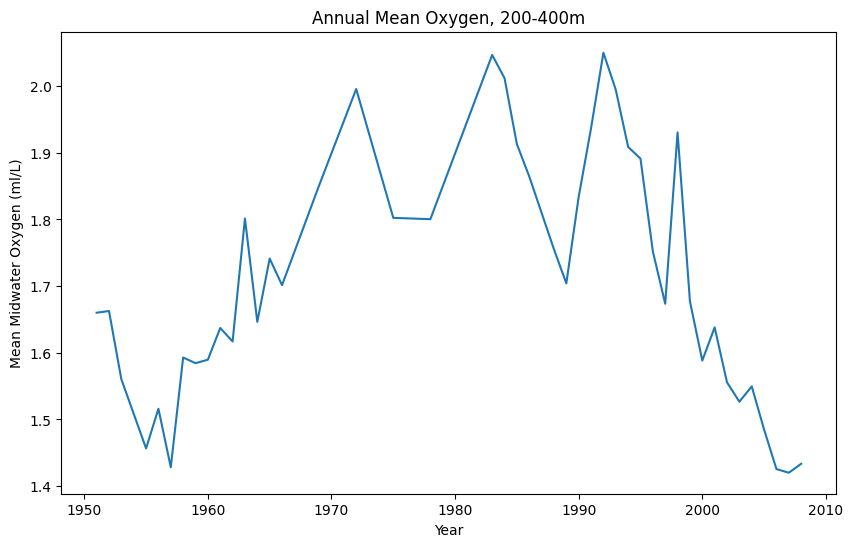

In [88]:
fig = plt.figure(figsize = (10, 6)) # set figure size

ax = fig.add_subplot(1, 1, 1) # subplot layout
ax.plot(annualOxygen["Year"], annualOxygen["O2ml_L"]); # variables to plot

ax.set_xlabel("Year") # set x axis label
ax.set_ylabel("Mean Midwater Oxygen (ml/L)") # set y axis label
ax.set_title("Annual Mean Oxygen, 200-400m") # set figure title

***

### 3. Analysis

Standardize taxa by mean and standard deviation.

In [113]:
# take the annualMeans df, cast it so that each taxon is a column
pca_data = (annualMeans.filter(["year", "scientific_name", "log10_larvae"]) # select variables
                       .pivot_table(values = "log10_larvae",
                                    index = "year",
                                    columns = "scientific_name") # cast to get a column for each taxon, and a row for each year
                       .fillna(0) # replace any NaN with 0; no larvae of that taxon were observed in that year
                       .reset_index() # make year a regular column 
            )

# show the first few rows of the new df
display(pca_data.head())

# write the pca-ready dataframe to csv file
pca_data.to_csv('pca_data.csv')

# standardize the features
features = pca_data.drop(columns=["year"]) # exclude the year column (index 0)

featsStScaled = StandardScaler().fit_transform(features) # StandardScaler's fit_transform method standardizes each column by its mean and standard deviation


scientific_name,year,Arctozenus risso,Argentina sialis,Argyropelecus affinis,Argyropelecus hemigymnus,Argyropelecus sladeni,Bathylagoides wesethi,Bathylagus pacificus,Benthalbella dentata,Brosmophycis marginata,...,Stomias atriventer,Symbolophorus californiensis,Symphurus atricaudus,Tarletonbeania crenularis,Tetragonurus cuvieri,Trachipterus altivelis,Trachurus symmetricus,Triphoturus mexicanus,Vinciguerria lucetia,Zaniolepis latipinnis
0,1951,0.0,0.421192,0.0,0.0,0.0,0.890774,0.748188,0.0,0.421604,...,0.379003,0.824036,0.000000,0.936578,0.566437,0.0,1.671308,0.975078,1.176334,0.0
1,1952,0.0,0.627024,0.0,0.0,0.0,1.151380,0.471850,0.0,0.751352,...,0.685219,0.956352,0.000000,1.141884,0.522966,0.0,1.621566,1.055548,1.106171,0.0
2,1953,0.0,0.606560,0.0,0.0,0.0,0.861404,0.563876,0.0,0.601299,...,0.579784,0.613842,0.328380,0.895070,0.371068,0.0,1.018834,0.823852,0.757443,0.0
3,1954,0.0,0.374290,0.0,0.0,0.0,1.111419,0.544585,0.0,0.755951,...,0.777185,0.610487,0.661813,0.829248,0.463395,0.0,1.883124,0.878787,0.999565,0.0
4,1955,0.0,0.535294,0.0,0.0,0.0,0.960336,0.468347,0.0,0.000000,...,0.434569,0.670967,0.000000,0.865487,1.139052,0.0,1.574244,0.992511,0.527630,0.0


Perform PCA using scikit-learn.

In [142]:
# apply PCA
pca1 = PCA(n_components=2) # how many dimensions to reduce to
principalComponents = pca1.fit_transform(featsStScaled) # apply PCA on the features

principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 'PC2']) # extract PC1 and PC2

# concatenate the years to the PC1 and PC2 series
finalDf = pd.concat([principalDf, pca_data[["year"]]], axis = 1)

# show the first few years of PC1 and PC2 scores
display(finalDf.head())

# get the explained variance
print("Explained variance ratio:", pca1.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca1.explained_variance_ratio_))

# store the eigenvectors
eigenvectors = pd.DataFrame(pca1.components_.T, columns = ["PC1", "PC2"])  # transpose to align with features
eigenvectorsDf = pd.concat([eigenvectors, pd.DataFrame(features.columns)], axis = 1) # add the sci_names back in

# get the loadings
loadings = pd.DataFrame(pca1.components_.T * np.sqrt(pca1.explained_variance_), columns = ["PC1", "PC2"])
loadingsDf = pd.concat([loadings, pd.DataFrame(features.columns)], axis = 1) # add the sci_names back in
display(loadingsDf.sort_values(by = "PC1", ascending = False)) # sort by largest to smallest and display

,PC1,PC2,year
0,-11.848733,-0.282005,1951
1,-8.028537,1.717011,1952
2,-10.142865,3.091162,1953
3,-8.012253,2.129687,1954
4,-8.167124,3.591551,1955


Explained variance ratio: [0.3467651  0.06764922]
Cumulative explained variance: [0.3467651  0.41441433]


,PC1,PC2,scientific_name
2,0.161713,-0.065742,Argyropelecus affinis
21,0.159920,-0.003836,Danaphos oculatus
4,0.157205,0.018672,Argyropelecus sladeni
10,0.155325,0.083747,Chauliodus macouni
61,0.155310,0.106303,Protomyctophum crockeri
...,...,...,...
19,0.006826,0.037101,Cyclothone
75,-0.007124,0.130085,Sebastes levis
88,-0.010404,0.125727,Trachurus symmetricus
18,-0.037760,0.029052,Cottidae


,PC1,PC2,scientific_name
2,0.923263,-0.165783,Argyropelecus affinis
21,0.913029,-0.009673,Danaphos oculatus
4,0.897530,0.047087,Argyropelecus sladeni
10,0.886793,0.211186,Chauliodus macouni
61,0.886707,0.268066,Protomyctophum crockeri
...,...,...,...
19,0.038974,0.093558,Cyclothone
75,-0.040674,0.328038,Sebastes levis
88,-0.059402,0.317048,Trachurus symmetricus
18,-0.215585,0.073260,Cottidae


[[ 0.11150348 -0.12555322]
 [ 0.14217476  0.08805223]
 [ 0.16171259 -0.06574212]
 [ 0.14436847 -0.00864573]
 [ 0.15720539  0.01867248]
 [ 0.0977142   0.02430855]
 [ 0.11260833 -0.0420731 ]
 [ 0.14838164 -0.04654498]
 [ 0.04670358  0.1599288 ]
 [ 0.12325275  0.00219706]
 [ 0.15532478  0.08374697]
 [ 0.09230998 -0.12318592]
 [ 0.02187801 -0.08261243]
 [ 0.07375594 -0.09444999]
 [ 0.06464245  0.11221108]
 [ 0.14790486  0.02450999]
 [ 0.13639143  0.06571882]
 [ 0.07164505  0.00203333]
 [-0.03776044  0.02905188]
 [ 0.00682647  0.03710086]
 [ 0.14696049 -0.10957263]
 [ 0.15992013 -0.00383579]
 [ 0.08487431  0.05799078]
 [ 0.14571639  0.03822819]
 [ 0.1271721  -0.07365508]
 [ 0.07418341  0.01925617]
 [ 0.12363973 -0.02004831]
 [ 0.07723692  0.04123053]
 [ 0.09555365 -0.12205164]
 [ 0.12439085 -0.14876843]
 [ 0.12555699 -0.07122968]
 [ 0.03484646  0.04138751]
 [ 0.12909821 -0.00030791]
 [ 0.1208348   0.047698  ]
 [ 0.14636152 -0.12505166]
 [ 0.00822605  0.12413198]
 [ 0.14655685  0.12421796]
 

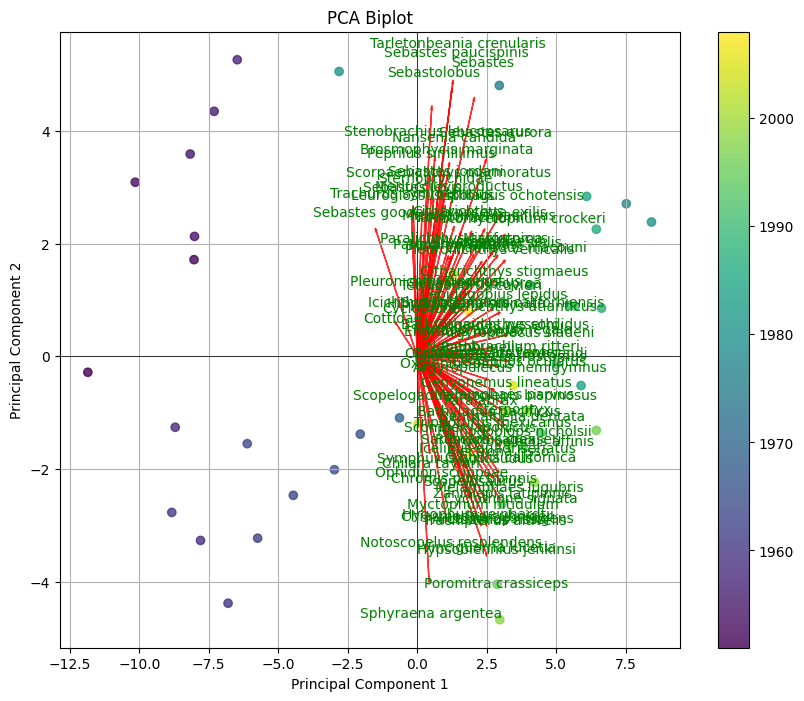

In [91]:
# trying to make a biplot

# define biplot function
def biplot(score, coeff, color_by, pc_names):
    # Create a scatter plot of the principal component scores
    plt.figure(figsize=(10, 8)) # set figure size
    plt.scatter(score[:, 0], score[:, 1], c = color_by, alpha=0.8) # make scatter plot
    
    # Add the feature vectors
    for i in range(coeff.shape[0]):
        plt.arrow(0, 0, coeff[i,0] * 20, coeff[i,1] * 20, color='r', alpha=0.8, head_width=0.05)
        plt.text(coeff[i,0]*23, coeff[i,1]*23, pc_names[i], color='g', ha='center', va='center')

    plt.xlabel('Principal Component 1') # set x axis label
    plt.ylabel('Principal Component 2') # set y axis label
    plt.title('PCA Biplot') # set figure title
    plt.grid(True) # add gridlines
    plt.colorbar() # add color bar
    plt.axhline(0, color='black',linewidth=0.5) # add y=0 line
    plt.axvline(0, color='black',linewidth=0.5) # add x=0 line
    plt.show() # display plot

# Get the principal component loadings
loadings = pca1.components_.T  # transpose to align with features
print(loadings)

# Feature names for labeling
feature_names = features.columns
print(feature_names)

# Create the biplot
biplot(principalComponents, loadings, finalDf["year"], feature_names)

Plot PC1 timeseries.

Text(0.5, 1.0, 'PC1 Time Series')

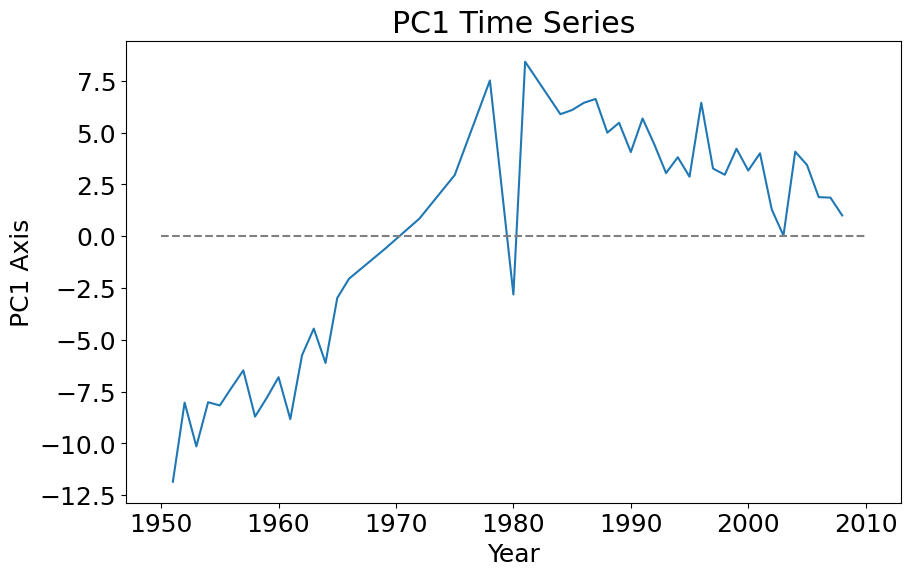

In [115]:
fig = plt.figure(figsize = (10, 6)) # set figure size

ax = fig.add_subplot(1, 1, 1) # subplot layout
ax.plot(finalDf["year"], finalDf["PC1"]); # variables to plot

ax.hlines(y = 0, xmin = 1950, xmax = 2010,
          colors='gray', linestyles='--', lw = 1.5) # add a y=0 line

ax.set_xlabel("Year") # set x axis label
ax.set_ylabel("PC1 Axis") # set y axis label
ax.set_title("PC1 Time Series") # set figure title

Try PCA from pca package.

[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [92] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


[scatterd] >INFO> Create scatterplot


     PC                    feature   loading  type
0   PC1      Argyropelecus affinis  0.161713  best
1   PC2  Tarletonbeania crenularis  0.241859  best
2   PC2           Arctozenus risso -0.125553  weak
3   PC1           Argentina sialis  0.142175  weak
4   PC1   Argyropelecus hemigymnus  0.144368  weak
..  ...                        ...       ...   ...
87  PC2     Trachipterus altivelis -0.126352  weak
88  PC2      Trachurus symmetricus  0.125727  weak
89  PC1      Triphoturus mexicanus  0.117639  weak
90  PC2       Vinciguerria lucetia -0.147688  weak
91  PC1      Zaniolepis latipinnis  0.133034  weak

[92 rows x 4 columns]


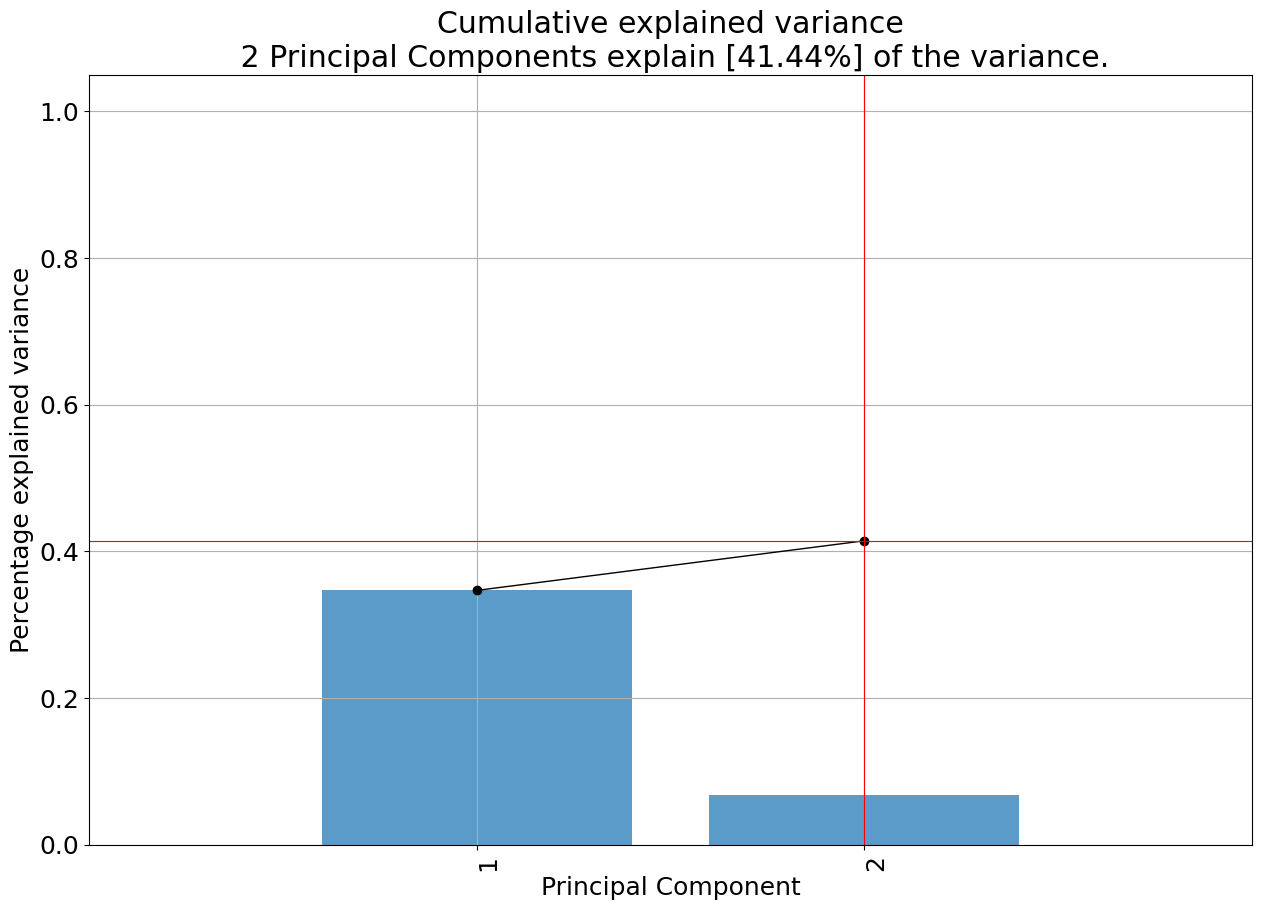

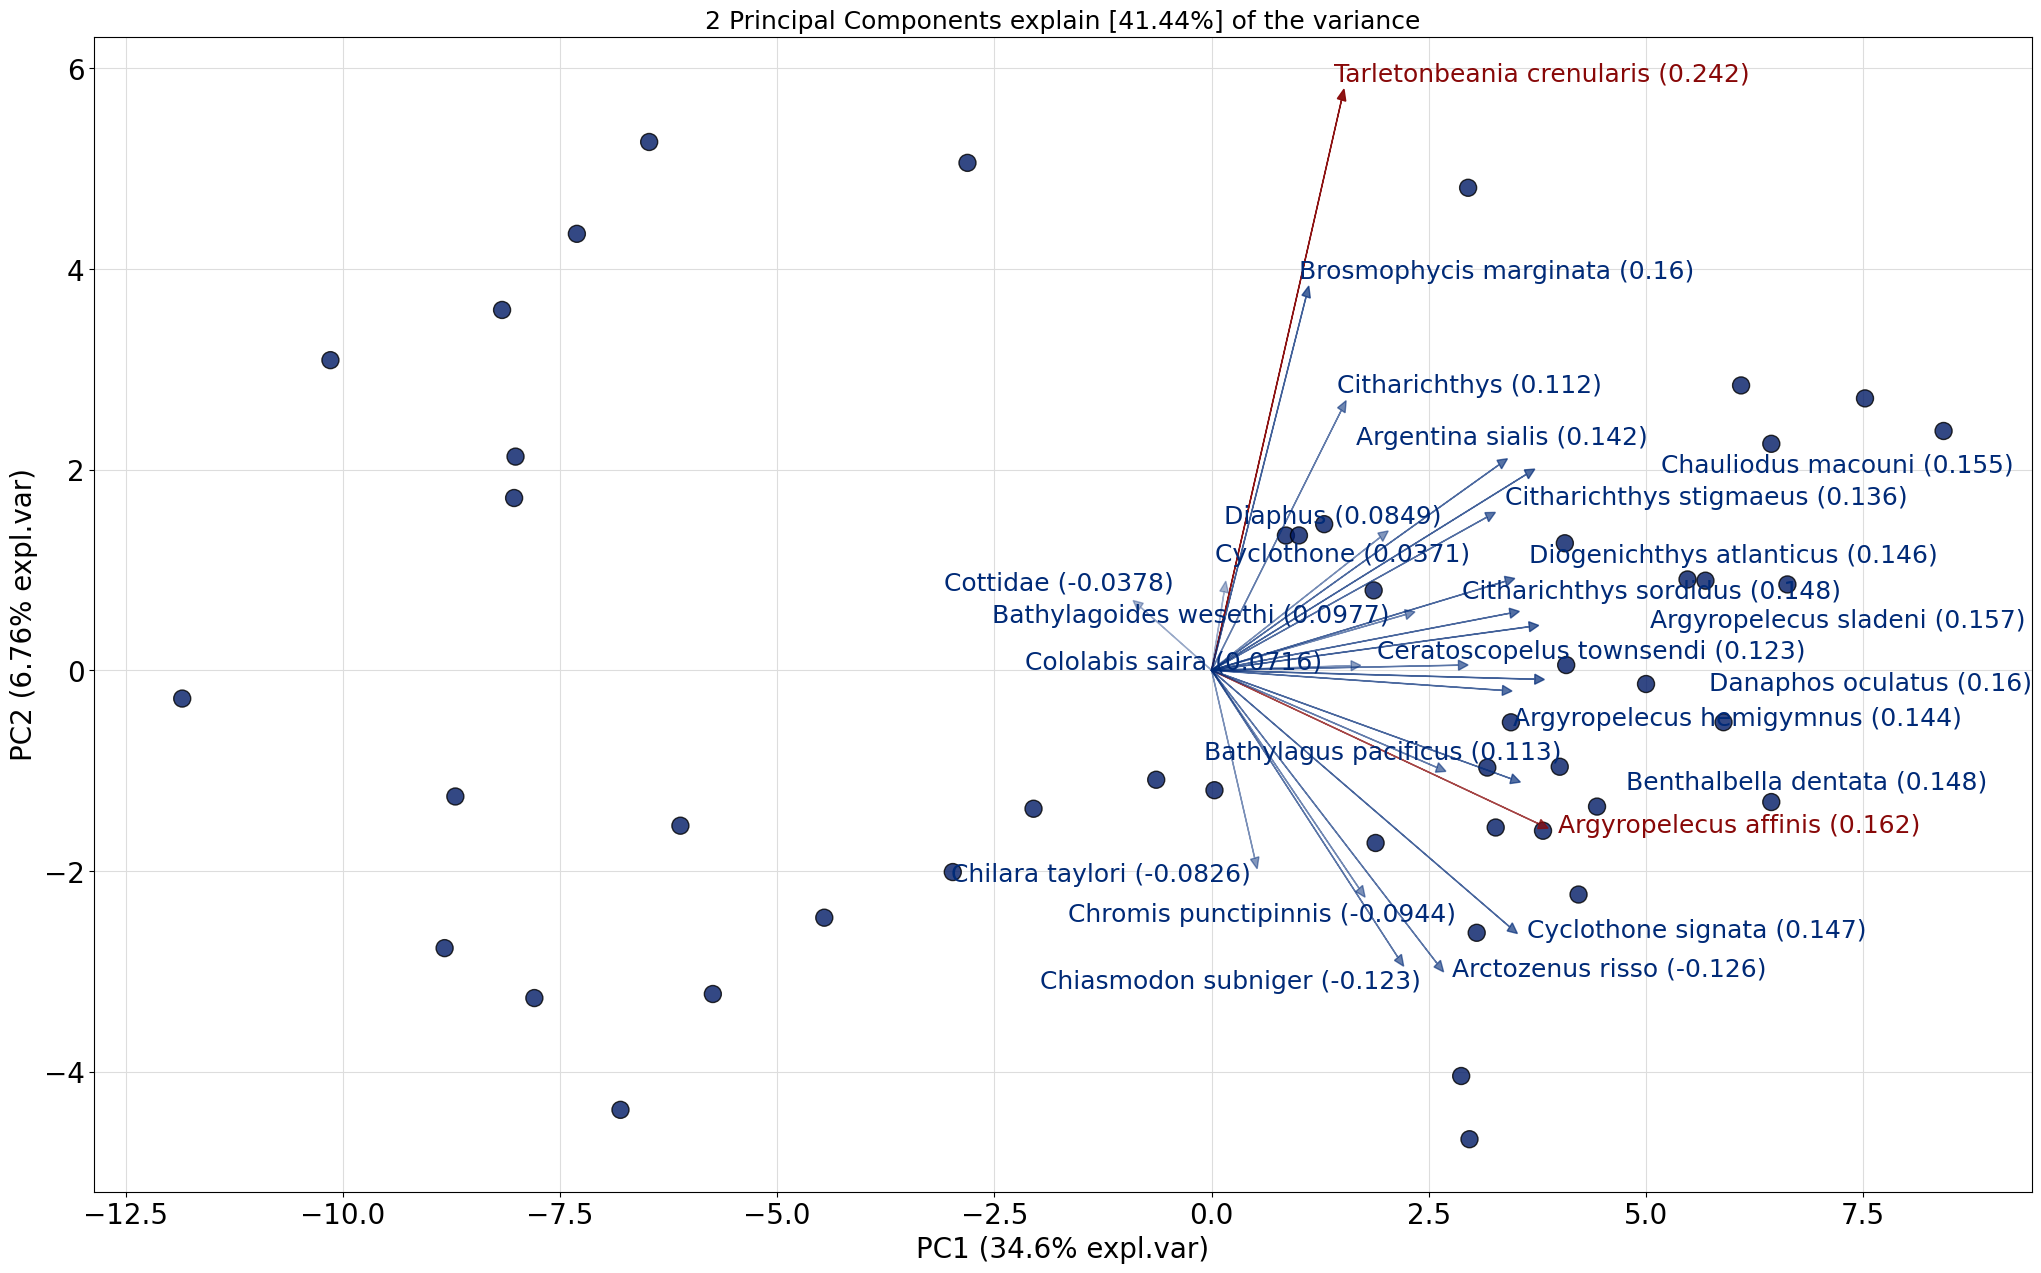

In [116]:
# initialize pca that will standardize the data and reduce to 2 dimensions
model = pca(normalize=True, n_components = 2)

# apply pca on the feature data
results = model.fit_transform(features, col_labels = features.columns, row_labels = pca_data["year"])

# show scree plot
model.plot()

# show biplot
model.biplot()

# best performing features
print(model.results['topfeat'])
#  Argyropelecus affinis contributes most to PC1, and Tarletonbeania crenularis contributes most to PC2

Try just getting the correlation between Diogenichthys atlanticus and PC1; paper has loading = 0.86.

In [140]:
Datlanticus = annualMeans.loc[annualMeans.scientific_name == "Diogenichthys atlanticus",:]
display(Datlanticus.head())

x = pd.Series(Datlanticus["log10_larvae"])
y = pd.Series(finalDf["PC1"])

corr, _ = pearsonr(x, y)
print('Pearsons correlation: %.3f' % corr)

,year,scientific_name,larvae_10m2,larvae_m2,log10_larvae,ln_larvae,ln_x1_larvae
18,1951,Diogenichthys atlanticus,5.710531,0.571053,0.756677,1.742312,1.903678
107,1952,Diogenichthys atlanticus,6.665708,0.666571,0.823846,1.896976,2.036757
198,1953,Diogenichthys atlanticus,4.338750,0.433875,0.637365,1.467586,1.674992
283,1954,Diogenichthys atlanticus,3.965833,0.396583,0.598334,1.377716,1.602581
378,1955,Diogenichthys atlanticus,3.658333,0.365833,0.563283,1.297008,1.538658


Pearsons correlation: 0.823


PC1 --> detrending, N* correction, first-differencing

...

***

### 4. Make Figures

Table 2: Taxa that contributed significantly to PC1 with their loadings, equivalent to their correlation with the PC1 timeseries.

Figure 2: Time series of four taxa that contributed significantly to PC1.

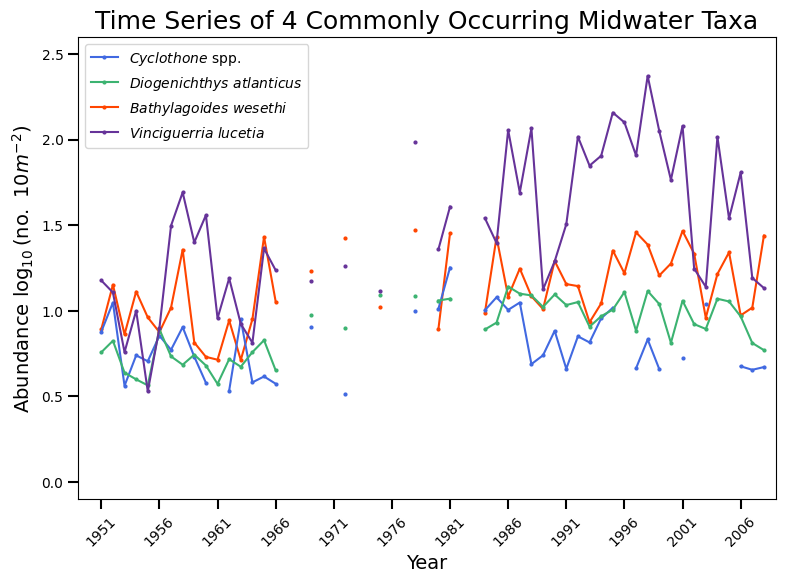

In [93]:
# the four taxa in this plot: Cyclothone spp., Diogenichthys atlanticus, Bathylagoides wesethi, Vinciguerria lucetia
# prepare df for plotting
fourTaxa = (annualMeans.filter(["year", "scientific_name", "log10_larvae"]) # get needed columns
            .loc[annualMeans.scientific_name.isin(["Cyclothone",
                                                   "Diogenichthys atlanticus",
                                                   "Bathylagoides wesethi",
                                                   "Vinciguerria lucetia"]),:] # get the four taxa in this figure
            )

# make a multi-index with all combinations of taxa and years
mux = pd.MultiIndex.from_product([
        fourTaxa.scientific_name.unique(),
        range(fourTaxa.year.min(), fourTaxa.year.max() + 1)
    ], names=['scientific_name', 'year'])

# use the multi-index to make NaN rows when a taxon is not observed in a given year. if there are no NaN rows, then the line plot will connect datapoints even if there are several-year-long gaps in sampling between them
fourTaxa = fourTaxa.set_index(['scientific_name', 'year']).reindex(mux).reset_index()


# figure layout
fig = plt.figure(figsize = (9, 6)) # set figure size
ax = fig.add_subplot(1, 1, 1) # subplot layout

# set colors-- choosing similar colors to those in the Koslow paper
ax.set_prop_cycle(color=['orangered', 'royalblue', 'mediumseagreen', 'rebeccapurple'])

# plot each of the four taxa
for i in fourTaxa.scientific_name.unique():
    # using a conditional statement for the legend labels. if sci_name is a genus and not a specific spp (recognized via lack of whitespace), make the label sci_name + 'spp.', else label it by sci_name. 
    if " " not in i:
        ax.plot(fourTaxa.loc[fourTaxa["scientific_name"] == i, "year"], # x variable
        fourTaxa.loc[fourTaxa["scientific_name"] == i, "log10_larvae"], # y variable
        '-o', ms = 2, # marker type and marker size
        label = "$\it{{{taxaLabel}}}$ spp.".format(taxaLabel = i)) # legend label
    else:
        ax.plot(fourTaxa.loc[fourTaxa["scientific_name"] == i, "year"], # x variable
            fourTaxa.loc[fourTaxa["scientific_name"] == i, "log10_larvae"], # y variable
            '-o', ms = 2, # marker type and marker size
            label = "$\it{{{taxaLabel}}}$".format(taxaLabel = i.replace(" ", "\ "))) # legend label. the replace() is needed here so that the surrounding mathtext will include the whitespace between the genus and species.

# set axes labels, limits, ticks
ax.set_xlabel("Year", fontsize = 14) # set x axis label
ax.set_xlim(1949, 2009) # set x axis limits
ax.set_xticks(np.arange(1951,2011, 5)) # set x axis ticks
ax.tick_params(axis = "x", labelrotation = 45) # rotate x axis labels

ax.set_ylabel("Abundance $\log_{10}(\mathrm{no.} \ 10m^{-2})$", fontsize = 14) # set y axis label
ax.set_ylim(-0.1, 2.6) # set y axis limits
ax.set_yticks(np.arange(0.0, 3, 0.5)) # set y axis ticks

ax.tick_params(axis = "both", length = 7, width = 1.5) # set length and width of axis ticks

# set figure title
ax.set_title("Time Series of 4 Commonly Occurring Midwater Taxa", fontsize = 18)

# add a legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0,3] # adjust the order of the legend items to match the order in the Koslow paper
legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) # make the legend

# display plot
plt.show()

Figure 3: Time series of PC1 and mean midwater oxygen (200-400m).